## Connecting to the Database

In [3]:
pip install psycopg2-binary;

Note: you may need to restart the kernel to use updated packages.


In [4]:
import psycopg2

In [5]:
# Put the password in 
PGHOST = 'tripdatabase2.cmaaautpgbsf.us-east-2.rds.amazonaws.com'
PGDATABASE = ''
PGUSER = 'postgres'
PGPASSWORD = 'Josh1234'

In [6]:
# Database Context Manager
try:   
    # Set up a connection to the postgres server.    
    conn = psycopg2.connect(user = PGUSER,
                            port = "5432",
                            password = PGPASSWORD,
                            host = PGHOST,
                            database = PGDATABASE)
    # Create a cursor object
    cursor = conn.cursor()   
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("Connection Success:", record,"\n")

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL", error)

Connection Success: ('PostgreSQL 12.4 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',) 



In [7]:
import pandas as pd
import numpy as np
import Queries
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

In [8]:
lookup_query = """SELECT * FROM lookup"""
lookup_table = Queries.execute_query(conn, lookup_query, to_frame=True)

In [9]:
pd.set_option('display.max_colwidth', -1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [10]:
profile_query = """
        with station_count AS (
            SELECT code, COUNT(*) 
              FROM station 
             WHERE birth <= '2020-01-01' 
                   AND (death >= '2020-01-01' 
                        or death IS NULL)
             GROUP BY code
        )
        SELECT *
          FROM profile
          LEFT JOIN station_count
         USING (code);
        """
profile_df = Queries.execute_query(conn, profile_query, to_frame=True)
profile_df.fillna(value={'count':0}, inplace=True)  # Neighborhoods with no stations are entered as null values
profile_df.replace(-1, np.nan, inplace=True)   # Missing data was inputted into the database as -1

In [11]:
profile_df.head()

,code,dem1,dem2,dem3,dem4,dem5,dem6,dem7,dem8,dem9,...,rnt8,rnt9,rnt10,rnt11,rnt12,rnt13,rnt14,rnt15,rnt16,count
0,BK01,0.518,0.059,0.200,0.239,8.1,0.714,81990.0,127140.0,74440.0,...,0.267,0.366,0.066,0.056,0.218,0.507,0.267,0.485,0.084,87.0
1,BK02,0.460,0.070,0.187,0.247,7.7,0.731,110230.0,163720.0,89540.0,...,0.265,0.408,0.160,0.049,0.154,0.442,0.192,0.392,0.067,68.0
2,BK03,0.588,0.078,0.195,0.283,7.2,0.648,55910.0,91750.0,46660.0,...,0.284,0.292,0.171,0.085,0.413,0.893,0.294,0.425,0.024,34.0
3,BK04,0.458,0.090,0.276,0.232,6.4,0.663,54240.0,92300.0,49620.0,...,0.271,0.298,0.108,0.070,0.409,0.851,0.318,0.459,0.019,59.0
4,BK05,0.545,0.068,0.356,0.379,5.5,0.580,42060.0,76180.0,34980.0,...,0.301,0.061,0.157,0.182,0.860,0.995,0.329,0.418,0.000,0.0


## Histograms of Data
Let's take some time to explore the data before we get into the machine learning portion. Since there are a lot of columns we are going to go category by category. The five categories are:
- DEM: Demographics
- HSC: Housing Market & Conditions
- LUD: Land Use & Development
- NSC: Neighborhood Services & Conditions
- RNT: Renters

## Demographics

In [12]:
dem = profile_df.loc[:,profile_df.columns.str[:3] == 'dem']

In [74]:
numbers = ['dem7','dem8','dem9','dem14']   # Columns that aren't percentages
percents = [i for i in list(dem.columns) if i not in numbers]   # Columns that are percentages 

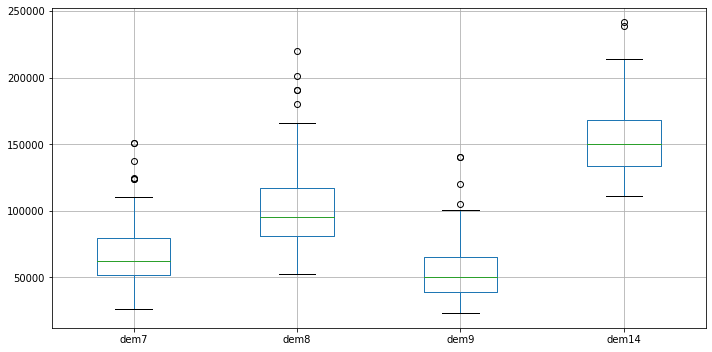

In [75]:
dem[numbers].boxplot(figsize=(10,5))
plt.tight_layout()

In [76]:
dem[numbers].describe()

,dem7,dem8,dem9,dem14
count,59.000000,59.000000,59.000000,59.000000
mean,68442.033898,106749.152542,56637.118644,153489.966102
std,30181.167500,36346.386733,27036.813731,29954.177078
min,26150.000000,52710.000000,23180.000000,110800.000000
25%,51750.000000,80900.000000,39460.000000,133329.500000
50%,62720.000000,95690.000000,50040.000000,150131.000000
75%,79995.000000,117055.000000,65160.000000,168311.000000
max,150600.000000,220070.000000,140090.000000,241539.000000


DEM8/9 are a subdivision of DEM7 which refers to the median household income of all members of the household aged 15 and over. I believe that this demographic will play a large role in determining the number of stations a neighborhood has. For example, lower income neighborhoods may be more attractive because those people would be looking for a cheaper alternative for transporation. On the flip side, higher income neighborhoods may be more attractive because they have more money to spend. 

DEM14 may also play a large role in deciding the number of stations. As we say in the last notebook the number of people each station serves divided by the voronoi area of the station tends to be under a threshold. 

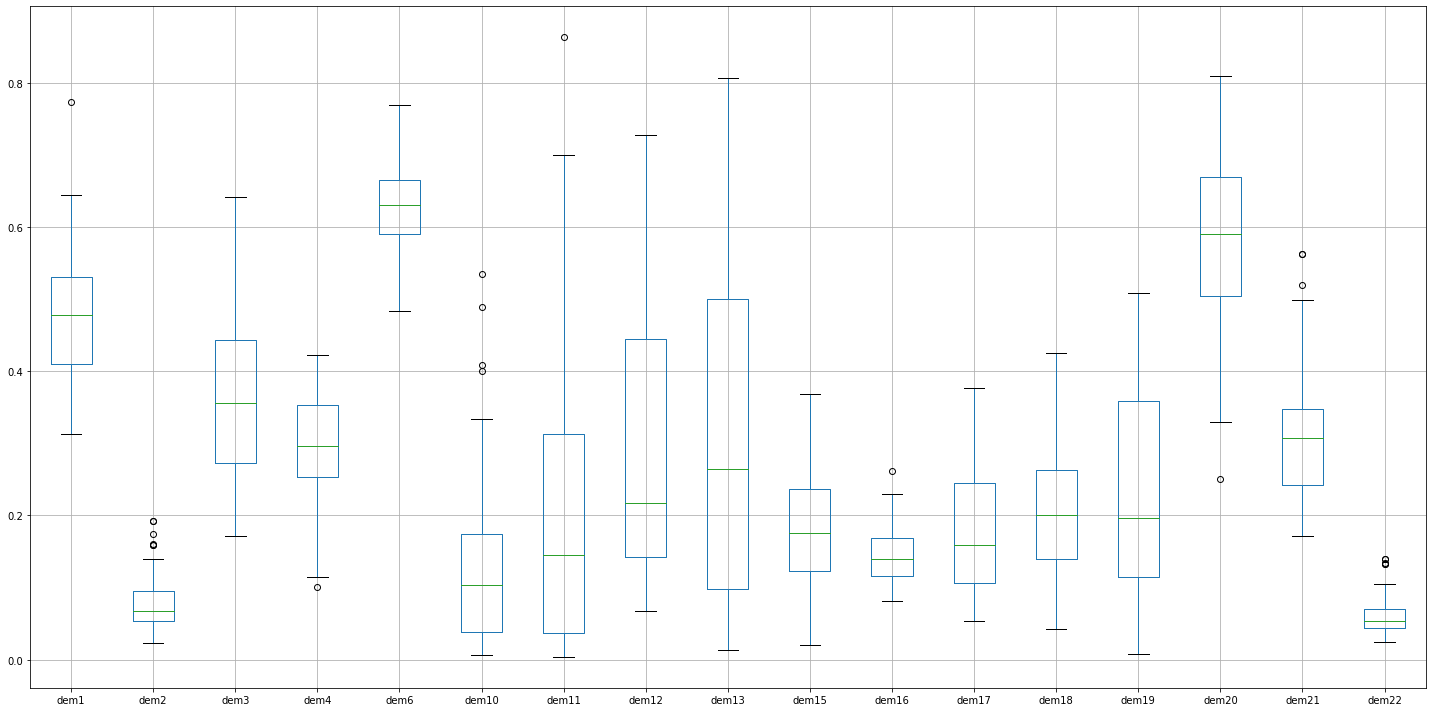

In [65]:
dem[percents].boxplot(figsize=(20,10))
plt.tight_layout()

In [79]:
dem[percents].describe()

,dem1,dem2,dem3,dem4,dem5,dem6,dem10,dem11,dem12,dem13,dem15,dem16,dem17,dem18,dem19,dem20,dem21,dem22
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.00000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,0.481356,0.080390,0.359017,0.291119,5.966102,0.63478,0.133492,0.214729,0.298169,0.321966,0.177644,0.145627,0.179576,0.204407,0.229068,0.581186,0.317881,0.060927
std,0.089503,0.040323,0.117478,0.081308,1.504546,0.06226,0.125464,0.220568,0.206382,0.241586,0.086797,0.040249,0.092851,0.092176,0.143636,0.108946,0.094711,0.028656
min,0.313000,0.023000,0.172000,0.101000,3.600000,0.48400,0.007000,0.004000,0.067000,0.013000,0.020000,0.082000,0.054000,0.043000,0.008000,0.250000,0.171000,0.024500
25%,0.409500,0.053500,0.272500,0.254000,4.800000,0.59100,0.039000,0.037000,0.142000,0.098500,0.123000,0.116500,0.106500,0.140000,0.115000,0.505000,0.242500,0.043800
50%,0.478000,0.068000,0.356000,0.297000,5.600000,0.63000,0.103000,0.145000,0.218000,0.264000,0.176000,0.139000,0.159000,0.201000,0.197000,0.590000,0.308000,0.053100
75%,0.530500,0.095500,0.443500,0.353000,6.850000,0.66550,0.174000,0.313000,0.444500,0.500000,0.237000,0.169000,0.245000,0.263000,0.359000,0.670000,0.347500,0.069750
max,0.774000,0.192000,0.642000,0.422000,9.700000,0.76900,0.535000,0.863000,0.728000,0.806000,0.368000,0.262000,0.377000,0.425000,0.509000,0.810000,0.562000,0.140200


DEM4 could be a huge factor in the number of stations an area has. Only people 16+ can use the service, and if there is a large percentage of houses with kids then that reduces the number of people that can use the service. On the flip side, that also can be seen as a potential spot for growth. If the company establishes their presence in those areas, then kids wouldn't be shy to try it when they are of age. Additionally, their parents might favor the bike share over getting a car, or even getting a bicycle. 

DEM6 as well because people that have jobs not only have money but have a place to go on a regular basis and requires transportation.

DEM2/16 could be a large influence because these are the people that most likely wouldn't use the bike share service

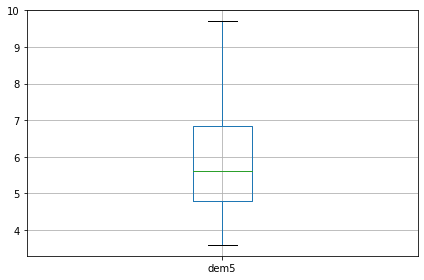

In [90]:
dem[['dem5']].boxplot()

NYC has a large gap between the 20th and 80th percentiles for the majority of neighborhoods. 'Naturally' the 80th percentile should be 4x more than the 20th percentile. If the 80th is less than 4x then that means the 'rich' people of the area don't make that much more money than the 'poor' people. If it's more than 4x than the 'rich' people of the area make significantly more than the 'poor' people. Almost every neighborhood in the city has an income diversity ratio of more than 4. The borough of Manhattan being the worst culprit, holding 7 spots in the top 10 highest income diversity ratios.

## Housing Market & Conditions

In [93]:
hsc = profile_df.loc[:,profile_df.columns.str[:3] == 'hsc']

In [96]:
hsc.

,hsc11,hsc18,hsc19,hsc20,hsc21,hsc22,hsc23,hsc24,hsc25,hsc26,...,hsc46,hsc47,hsc48,hsc49,hsc50,hsc51,hsc52,hsc53,hsc54,hsc55
0,0.002,21.7,0.242,0.024,0.158,71130.0,545.8,708.5,792.5,487.4,...,10.2,0.026,10.0,120.0,60.0,744.0,554.0,28.5,0.038,173.6
1,0.000,27.8,0.115,0.013,0.313,68858.0,590.6,557.3,629.7,474.9,...,11.9,0.032,24.0,88.0,36.0,655.0,507.0,19.6,0.037,101.5
2,0.021,21.1,0.668,0.025,0.240,61257.0,587.7,471.6,776.8,466.0,...,17.1,0.050,23.0,402.0,50.0,741.0,266.0,76.2,0.039,393.1
3,0.039,20.0,0.993,0.034,0.135,50529.0,365.8,452.7,608.0,460.4,...,15.8,0.038,12.0,212.0,43.0,350.0,83.0,97.0,0.036,462.4
4,0.504,18.5,0.766,0.068,0.273,66650.0,260.4,260.1,350.4,264.6,...,17.6,0.049,94.0,451.0,18.0,610.0,47.0,101.3,0.051,495.2


In [38]:
profile_df.loc[:,profile_df.isna().any()]   # Rows that have missing data

,hsc23,hsc24,hsc25,hsc27,hsc30,hsc31,hsc32,hsc33,rnt11,rnt12,rnt13
0,545.8,708.5,792.5,411.6,1840000.0,735620.0,349480.0,962000.0,0.056,0.218,0.507
1,590.6,557.3,629.7,262.7,3647220.0,1075000.0,425340.0,1315000.0,0.049,0.154,0.442
2,587.7,471.6,776.8,464.6,994500.0,500000.0,307810.0,750000.0,0.085,0.413,0.893
3,365.8,452.7,608.0,428.0,732500.0,469580.0,287500.0,580000.0,0.070,0.409,0.851
4,260.4,260.1,350.4,188.1,435000.0,280000.0,162670.0,320000.0,0.182,0.860,0.995
5,438.9,497.3,899.8,308.3,3300000.0,1000000.0,450000.0,1346590.0,0.029,0.135,0.550
6,504.8,479.7,544.1,457.7,1450000.0,625000.0,301670.0,793500.0,0.039,0.615,0.921
7,543.0,409.6,772.1,385.0,981500.0,500000.0,316520.0,1081780.0,0.048,0.383,0.832
8,442.4,480.7,761.4,578.3,1400000.0,472500.0,250000.0,674100.0,0.067,0.509,0.950
9,306.2,338.0,707.1,141.5,980000.0,565000.0,250000.0,655840.0,0.039,0.680,0.973


Things to Mention:
- Values that are between 0 and 1 were percentages. For example DEM1 is the percentage of people born in the state of NY. For BK01 that statement applies to 51.8 percent of the total population